# Recover Functional Connectivity from Block-Missing Neural Signals


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from scipy import linalg
import seaborn as sns
import time


import globals as glb
import utils_plot as putils
from data_loader import RecordingData, SpontaneousRecordingData
from data_sampler import MissingTraceSampler, PartialSpontRecordingData
from recover_fconnectivity import *
import evals
from main import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Pre-load all 9 sessions

In [3]:
DATA_DIR = "../../Data/"
spont_mats = scipy.io.loadmat(DATA_DIR + "dbspont.mat").get("db")[0]  # 9 datasets of recordings

loaded_spontData = []
for sidx in range(7):
    spont_fp = DATA_DIR + "_".join(["spont", spont_mats[sidx][glb.SESSION_NAME][0], spont_mats[sidx][glb.REC_DATE][0]])
    spont_dataset = SpontaneousRecordingData(data_fp=spont_fp)
    loaded_spontData.append(spont_dataset)
    print(sidx, spont_dataset.session_name, spont_dataset.layer_counts)

Removing 1 all-zero columns
0 M150824_MP0192016-04-05 9
Removing 1 all-zero columns
Removing 7 zero-variance neurons
1 M160907_MP0282016-09-26 11
Removing 1 all-zero columns
Removing 3 zero-variance neurons
2 M160825_MP0272016-12-12 11
Removing 849 zero-variance neurons
3 M161025_MP0302016-11-20 10
Removing 1 all-zero columns
4 M161025_MP0302017-06-16 11
Removing 1 all-zero columns
Removing 1 zero-variance neurons
5 M161025_MP0302017-06-23 11
Removing 3 zero-variance neurons
6 M170714_MP0322017-08-04 11


In [4]:
for i in range(6):
    print(loaded_spontData[i].session_name)
    

M150824_MP0192016-04-05
M160907_MP0282016-09-26
M160825_MP0272016-12-12
M161025_MP0302016-11-20
M161025_MP0302017-06-16
M161025_MP0302017-06-23


# Create partial dataset
## Sample Missing Data by Layers (continuous)

In [ ]:
sampler = MissingTraceSampler()

In [ ]:
plt.rcParams['figure.figsize'] = [14, 12]
# adjust layer_stride to allow for overlaps in two partial observation sections
missing_fsp_cont = sampler.missing_fsp_consecutive_layers(dataset=partial_spont0, sim_timestamps=30, sim_layer_size=4, 
                                                          layer_stride=1, display=True)


## Sample Missing Data by Layers (interleaving)

In [ ]:
sampler = MissingTraceSampler()

In [ ]:
missing_fsp_cont = sampler.missing_fsp_interleaving_layers(dataset=partial_spont0, sim_timestamps=21, 
                                                           sim_layer_size=3, display=True)


# Missing Pattern: Consecutive Layers of Simultaneous Neuron Blocks
### Stride = 1

In [5]:
#   sessions: list
#   time_range: tuple
#   sim_timestamps: int
#   loaded_sessions: List[RecordingData] = None
#   auxi_mask: list = None
#   layersOI: np.ndarray = np.arange(4)
#   xrange: tuple = (0.1, 0.3)
#   yrange: tuple = (0.1, 0.3)
#   ratio: bool = True
#   init_useCorr: bool = True
#   sim_layer_size: int = 1
#   layer_stride: int = 1
#   psd_corrector: str = glb.NEWTON
#   full_glasso_alpha: float = None
#   full_Kfolds: int = None
#   full_gamma: float = 0
#   glasso_alpha: float = None
#   Kfolds: int = None
#   gamma: float = 0
#   rec_model: str = glb.LINEAR_REG
#   edge_types: int = 2
#   edge_cutoff_tol: float = 1e-8
#   edge_cutoff_qt: float = 0.05


# session 0, 2, 3, 7
# tuning_curve predictor failed: 1, 4, 5 (TODO: debug this, might relate to binrange for each auxi info)

fcr_config = FCRecoveryConfig(sessions=[0, 1, 2], loaded_sessions=loaded_spontData, time_range=(100, 1100), 
                              sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.33, 0.66), yrange=(0.33, 0.66), 
                              sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.5, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [ ]:
session2res_consec = diff_session_diff_missing_by_layers(fcr_config, consecutive=True)


In [ ]:
for k in session2res_consec.keys():
    print("\n\nSession: %s" % k)
    print("Number of neurons: ", session2res_consec[k]['missing_fsp'].shape[0])
    print(session2res_consec[k]['result'])

## Vary Lambda in Glasso

In [36]:
fcr_config = FCRecoveryConfig(sessions=[0,1,3,4,5], loaded_sessions=loaded_spontData, 
                              time_range=(100, 5100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.3, 0.6), yrange=(0.4, 0.6), 
                              sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_Kfolds=5, glasso_alpha=0.15, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [39]:
lambdas=[0.01, 0.03, 0.1, 0.12, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
session2res_consec_lams = diff_session_diff_lambda(fcr_config, lambdas, consecutive=True)



9 datasets to loaded

Session 0 loaded:  M150824_MP0192016-04-05
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 0: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Session 0 under Different Lambdas Comparison Finished!


Session 1 loaded:  M160907_MP0282016-09-26
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning

Session 1: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 1 under Different Lambdas Comparison Finished!


Session 3 loaded:  M161025_MP0302016-11-20
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 3: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 3 under Different Lambdas Comparison Finished!


Session 4 loaded:  M161025_MP0302017-06-16
start, end time:  100 5100


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 4: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Session 4 under Different Lambdas Comparison Finished!


Session 5 loaded:  M161025_MP0302017-06-23
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 5: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Final Correlation matrix contains NaN? False
Session 5 under Different Lambdas Comparison Finished!



In [93]:
print(session2res_consec_lams.keys())

dict_keys(['M150824_MP0192016-04-05', 'M160907_MP0282016-09-26', 'M161025_MP0302016-11-20', 'M161025_MP0302017-06-16', 'M161025_MP0302017-06-23'])


M150824_MP0192016-04-05 (314 neurons)  selected lamda on full data:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
M160907_MP0282016-09-26 (335 neurons)  selected lamda on full data:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
M161025_MP0302016-11-20 (261 neurons)  selected lamda on full data:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
M161025_MP0302017-06-16 (306 neurons)  selected lamda on full data:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
M161025_MP0302017-06-23 (201 neurons)  selected lamda on full data:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


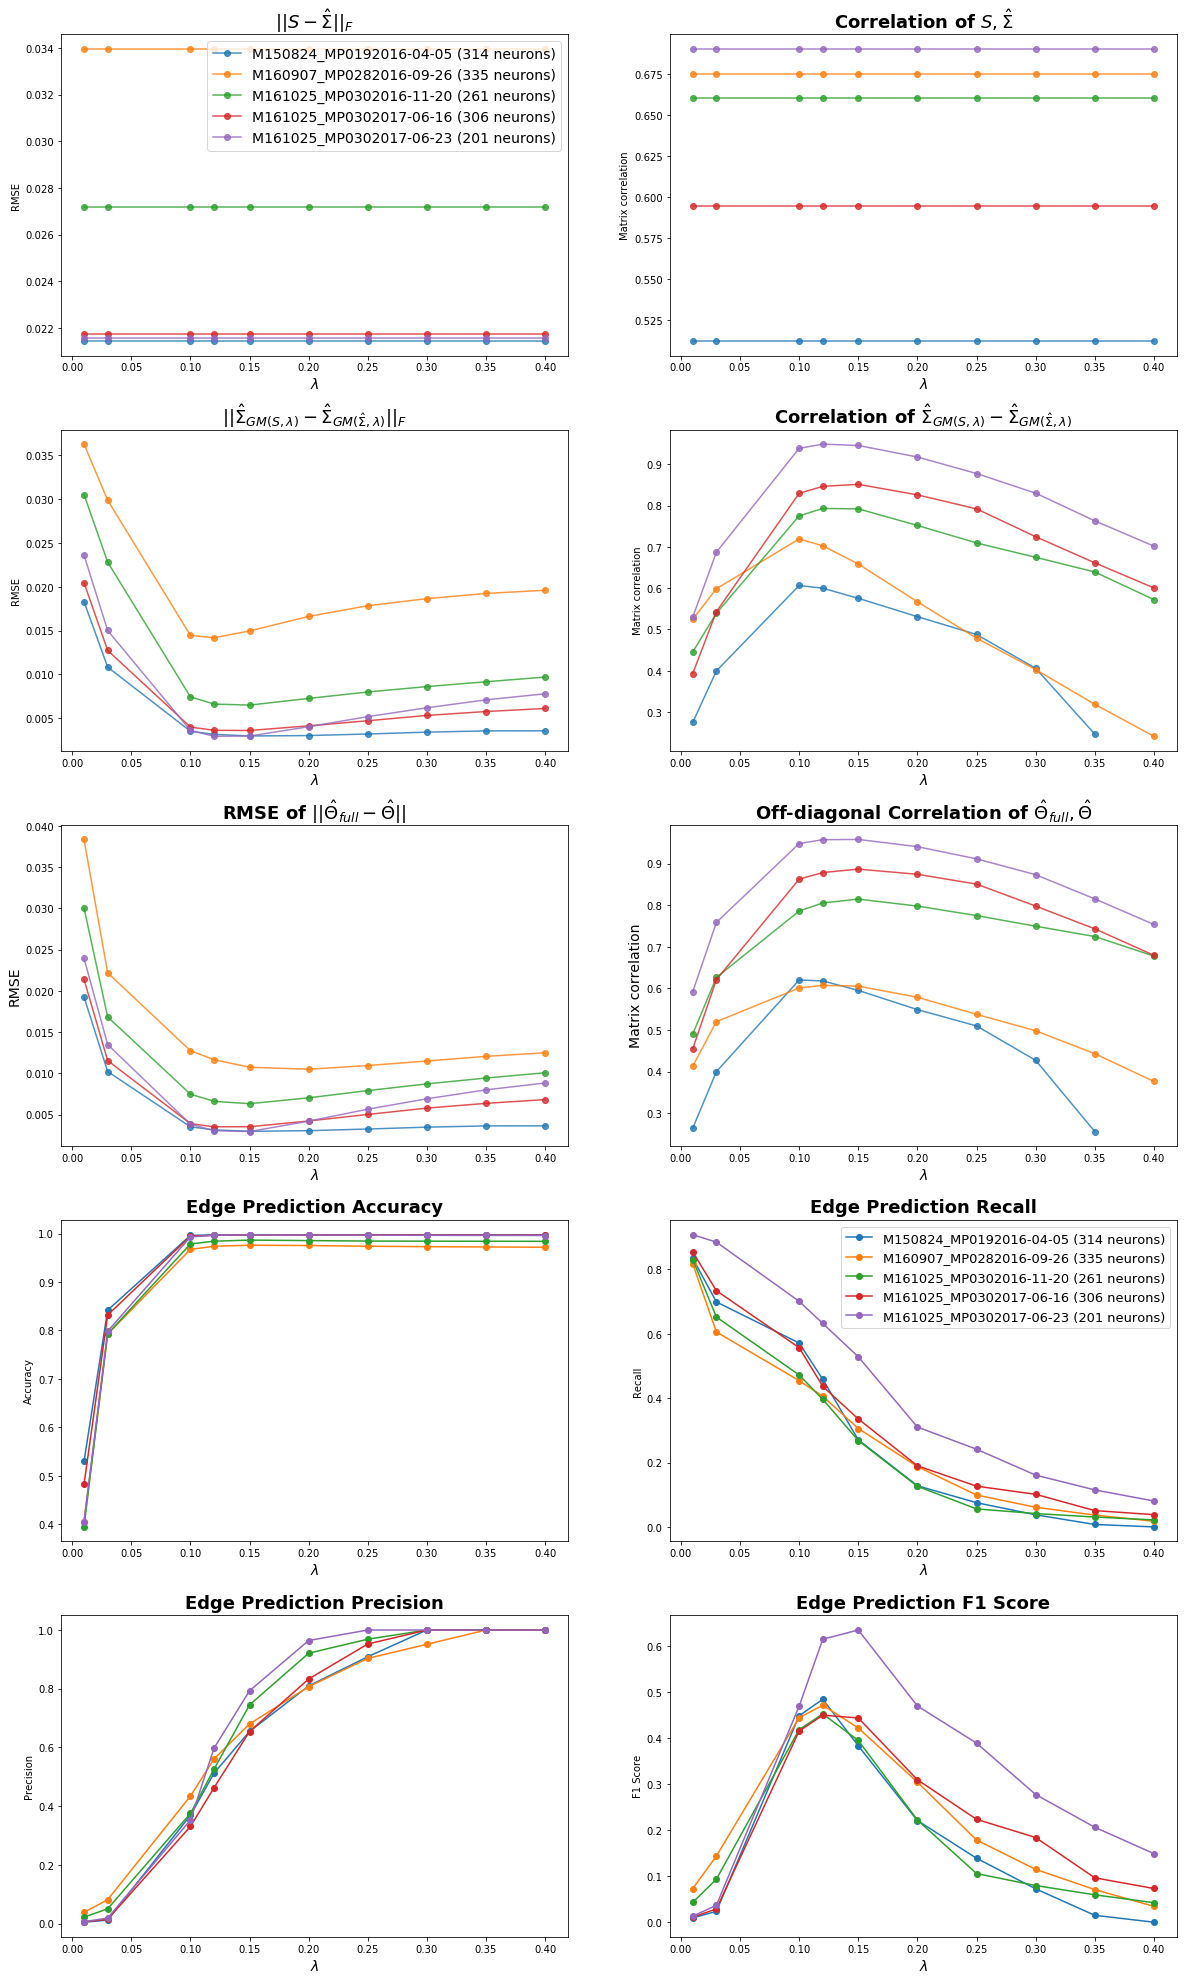

In [99]:

putils.display_results_diff_lambdas(lambdas, session2res_consec_lams)


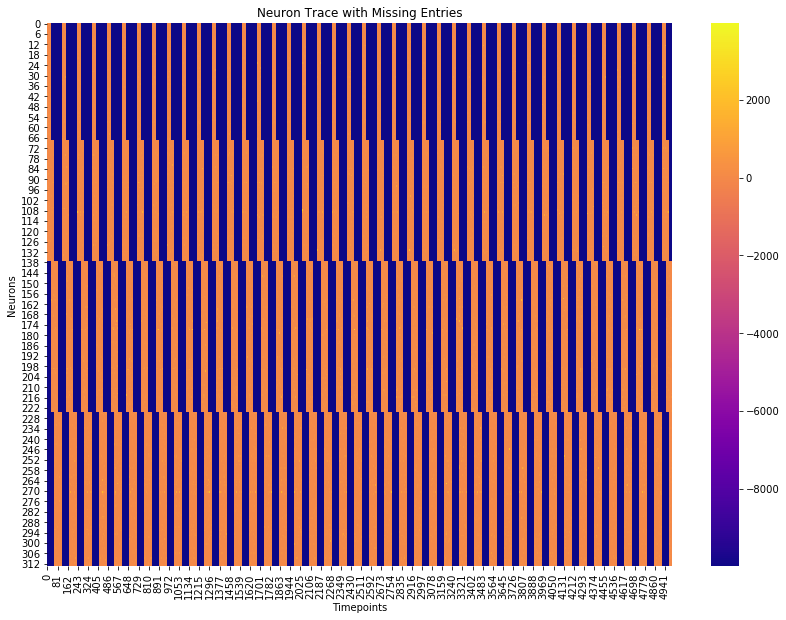

In [97]:
plt.rcParams['figure.figsize'] = (14, 10)
putils.display_missing_fsp(session2res_consec_lams['M150824_MP0192016-04-05']['missing_fsp'])



## Vary Gaussian Kernel Sigma

In [33]:
# Use only gaussian kernel ridge regression
fcr_config = FCRecoveryConfig(sessions=[0,1,3,4,5], loaded_sessions=loaded_spontData, 
                              time_range=(100, 5100), sim_timestamps=30, auxi_mask=[0,0,0,0,0,0,0,0,0,1,1,1,1], 
                              layersOI=np.arange(4), xrange=(0.3, 0.6), yrange=(0.4, 0.6), 
                              sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_Kfolds=5, glasso_alpha=0.15, rec_model=glb.RIDGE_REG,
                              edge_types=2, edge_cutoff_tol=1e-8)

In [34]:
gsk_sigmas = [0.1]

session2res_consec_sigmas = diff_session_diff_gaussK_sigma(fcr_config, gsk_sigmas, consecutive=True)


9 datasets to loaded

Session 0 loaded:  M150824_MP0192016-04-05
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 0: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 0 under Different Gaussian Kernel Sigma Finished!


Session 1 loaded:  M160907_MP0282016-09-26
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 1: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 1 under Different Gaussian Kernel Sigma Finished!


Session 3 loaded:  M161025_MP0302016-11-20
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 3: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 3 under Different Gaussian Kernel Sigma Finished!


Session 4 loaded:  M161025_MP0302017-06-16
start, end time:  100 5100


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 4: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 4 under Different Gaussian Kernel Sigma Finished!


Session 5 loaded:  M161025_MP0302017-06-23
start, end time:  100 5100


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Sample Correlation Matrix is positive definite!
Session 5: Pairwise Similarity Matrices Created!
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Session 5 under Different Gaussian Kernel Sigma Finished!



M150824_MP0192016-04-05 (314 neurons)  selected lamda on full data:  [0.1]
M160907_MP0282016-09-26 (335 neurons)  selected lamda on full data:  [0.1]
M161025_MP0302016-11-20 (261 neurons)  selected lamda on full data:  [0.1]
M161025_MP0302017-06-16 (306 neurons)  selected lamda on full data:  [0.1]
M161025_MP0302017-06-23 (201 neurons)  selected lamda on full data:  [0.1]


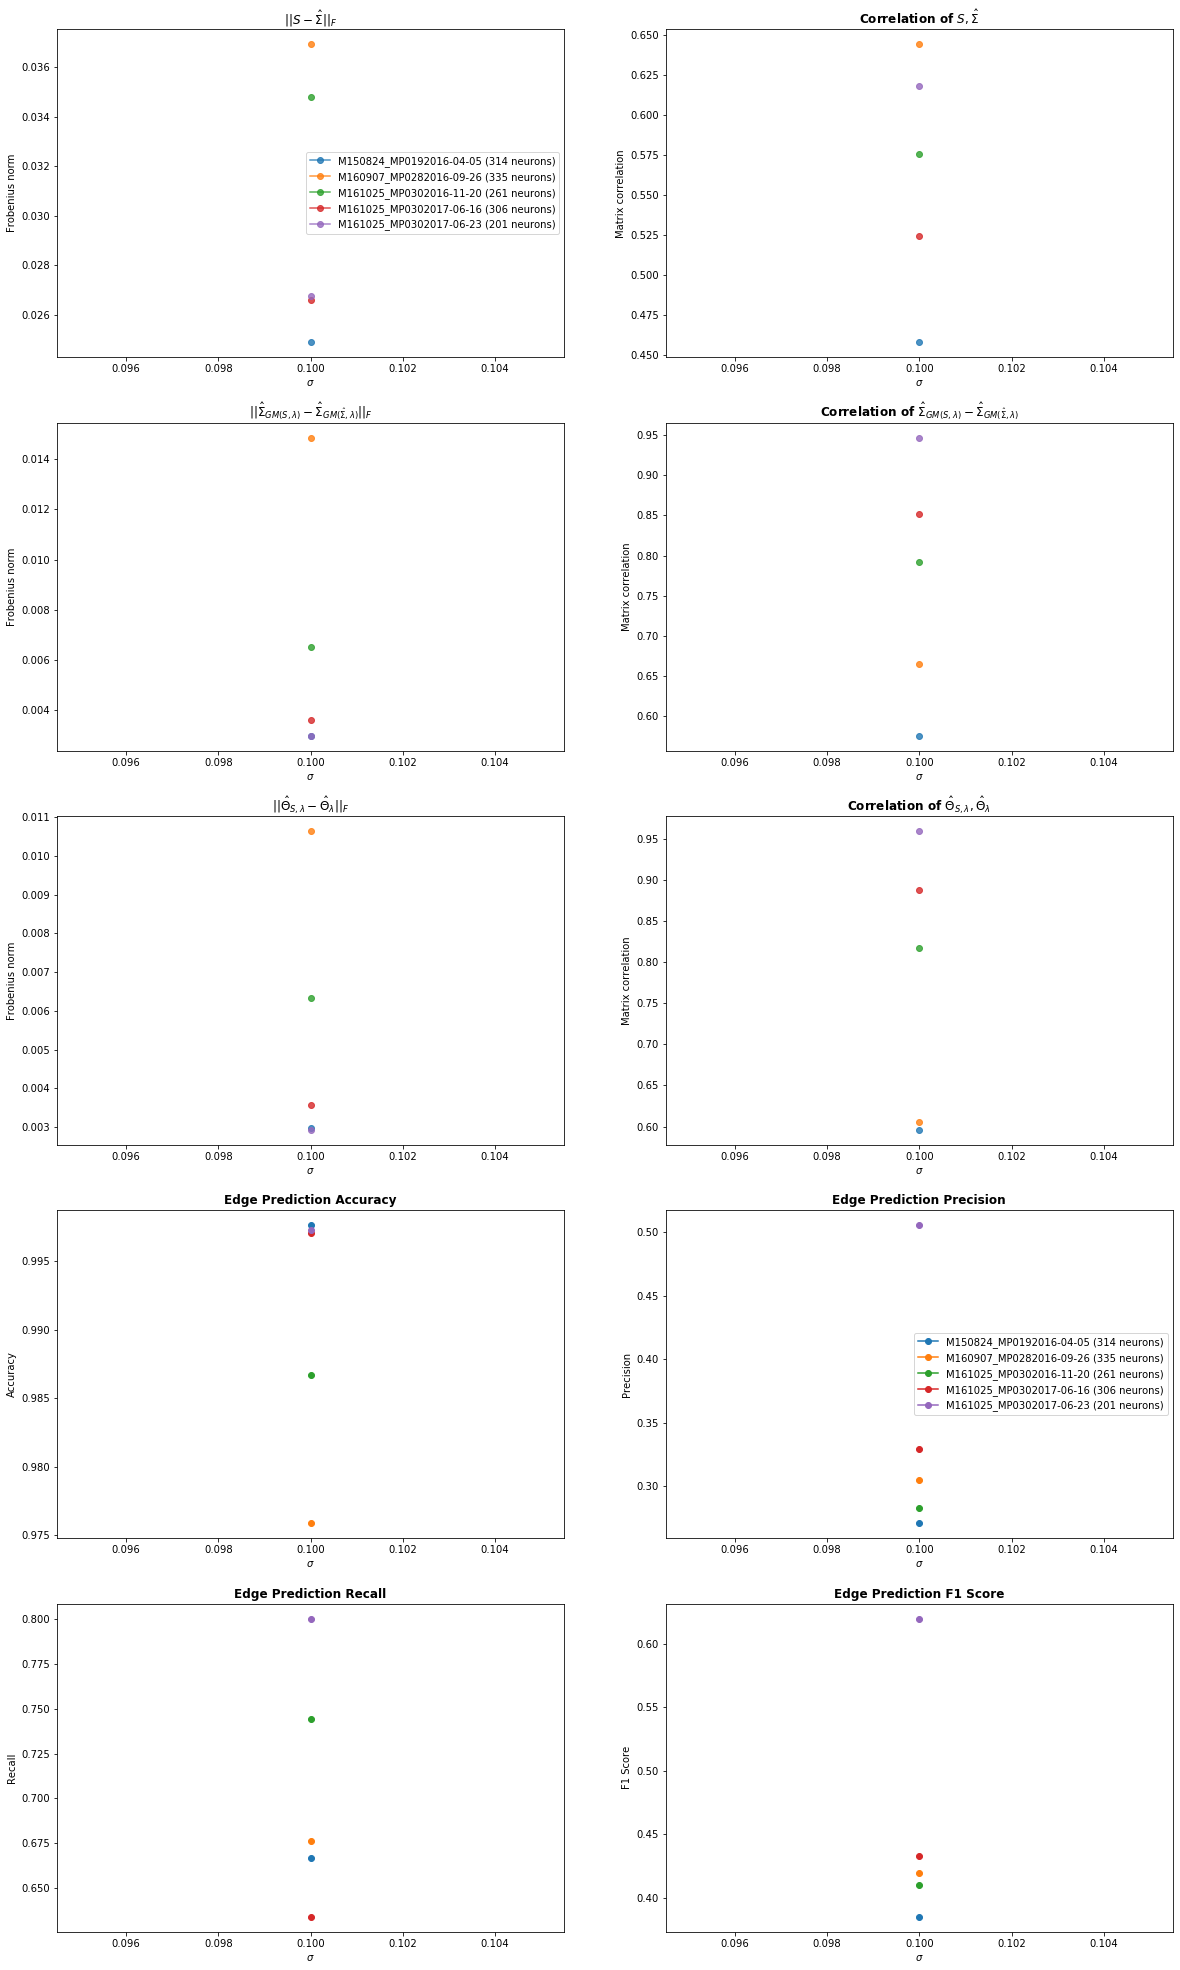

In [35]:

putils.display_results_diff_lambdas(gsk_sigmas, session2res_consec_sigmas, varIsLam=False)



## Vary Auxiliary Features

In [6]:
total_features = 13
auxi_masks = list(np.identity(total_features)) + [[1,1,1,1,1,0,0,0,0,0,0,0,0], 
                                                  [1,0,0,0,0,1,1,1,1,0,0,0,0], 
                                                  [1,0,0,0,0,0,0,0,0,1,1,1,1]]

auxi_labels = ["Distance", "Pupil area (corr)", "Pupil area change (corr)", "Run speed (corr)", "Acceleration (corr)", 
               "Pupil area (cos)", "Pupil area change (cos)", "Run speed (cos)", "Acceleration (cos)",
               "Pupil area (rbf)", "Pupil area change (rbf)", "Run speed (rbf)", "Acceleration (rbf)",
               "All Five (corr)", "All Five (cos)", "All Five (rbf)"]


## <font color='LightCoral'> Model: Linear Regression </font>

In [7]:
fcr_config = FCRecoveryConfig(sessions=[0,1,3,4,5], loaded_sessions=loaded_spontData, 
                              time_range=(100, 5100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.3, 0.6), yrange=(0.4, 0.6), 
                              sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_Kfolds=5, glasso_alpha=0.15, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [8]:
session2res_auxi = diff_session_diff_auxi(fcr_config, auxi_masks, consecutive=True)


9 datasets to loaded

Session 0 loaded! M150824_MP0192016-04-05
start, end time:  100 5100


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 0: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (5, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 314, 314)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Session 0 Auxiliary Info Comparison Finished!


Session 1 loaded! M160907_MP0282016-09-26
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 1: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 335, 335)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Session 1 Auxiliary Info Comparison Finished!


Session 3 loaded! M161025_MP0302016-11-20
start, end time:  100 5100


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 3: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 261, 261)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Session 3 Auxiliary Info Comparison Finished!


Session 4 loaded! M161025_MP0302017-06-16
start, end time:  100 5100


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 4: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (5, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 306, 306)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Session 4 Auxiliary Info Comparison Finished!


Session 5 loaded! M161025_MP0302017-06-23
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 5: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (5, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (5, 201, 201)


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Final Correlation matrix contains NaN? False
Session 5 Auxiliary Info Comparison Finished!



Optimal Lambda for full data:  None
Optimal Lambda for full data:  None
Optimal Lambda for full data:  None
Optimal Lambda for full data:  None
Optimal Lambda for full data:  None


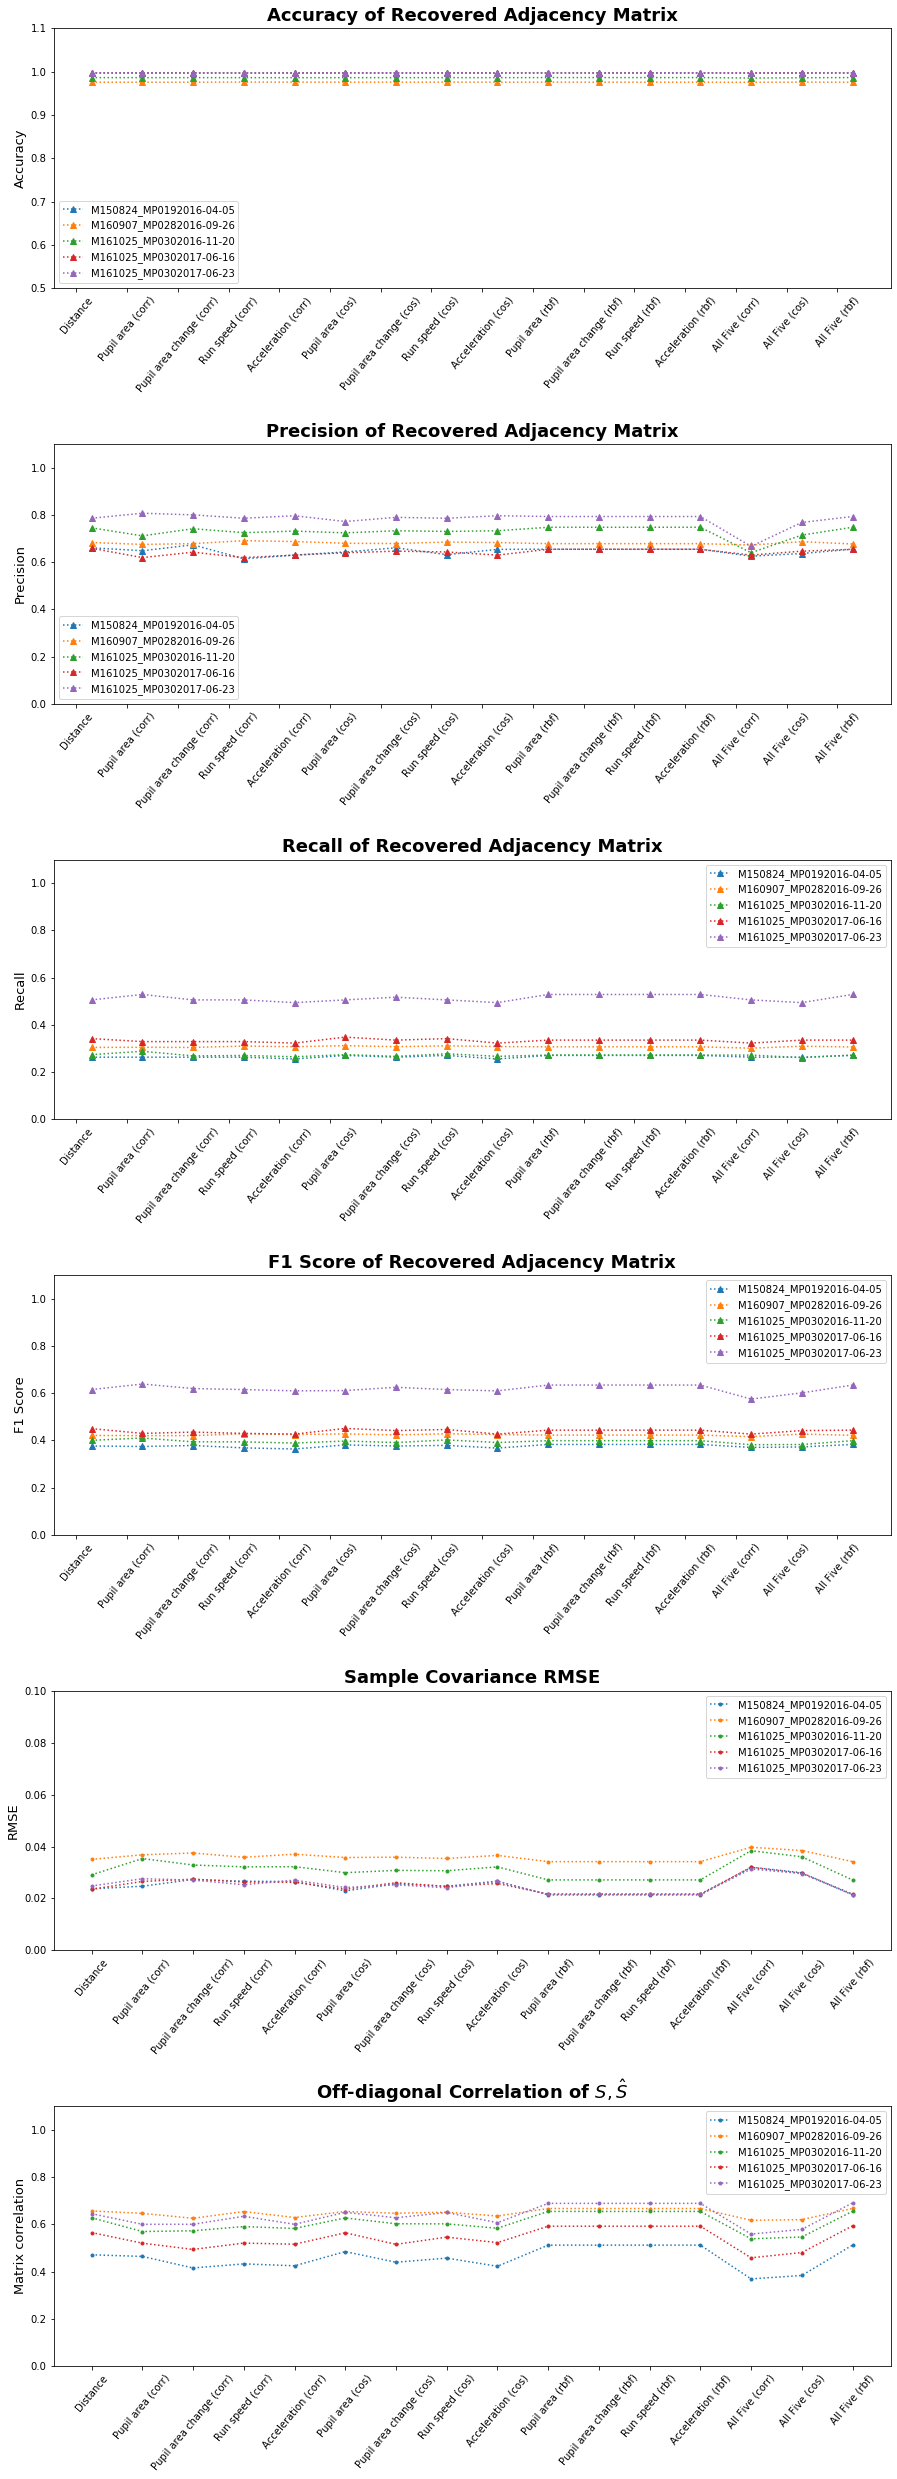

In [9]:
putils.display_results_diff_auxi_show_all_sessions(auxi_labels, session2res_auxi)


Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

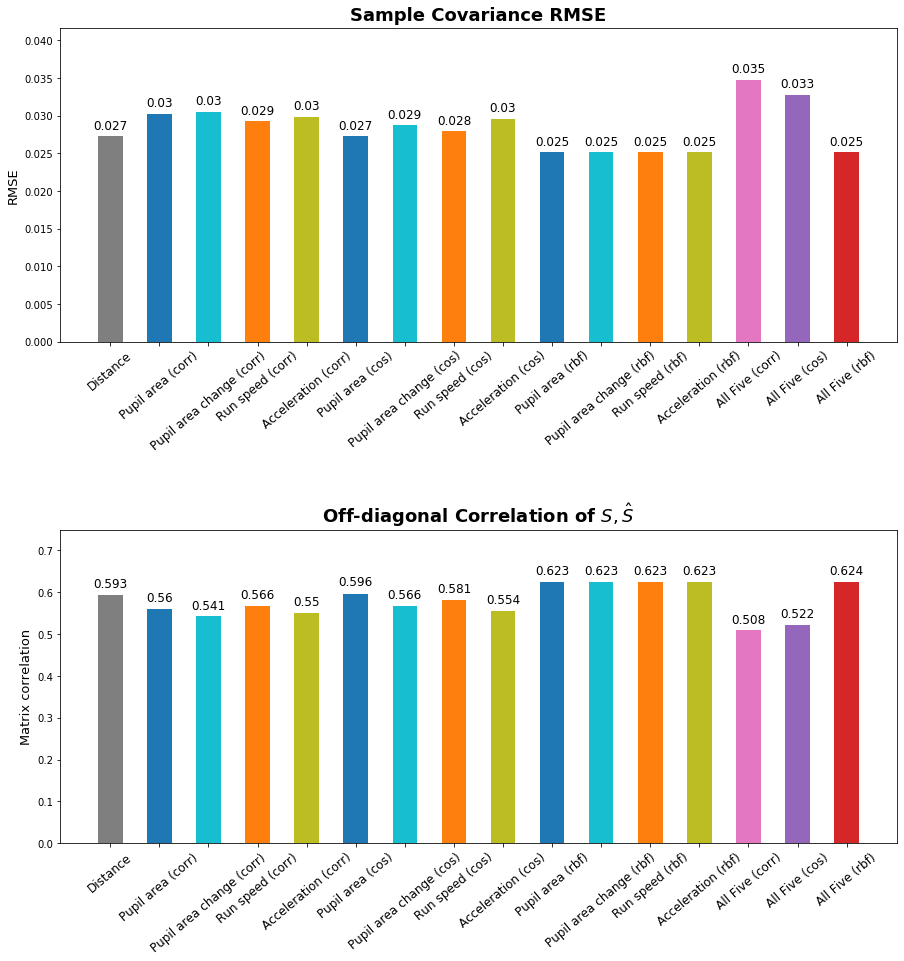

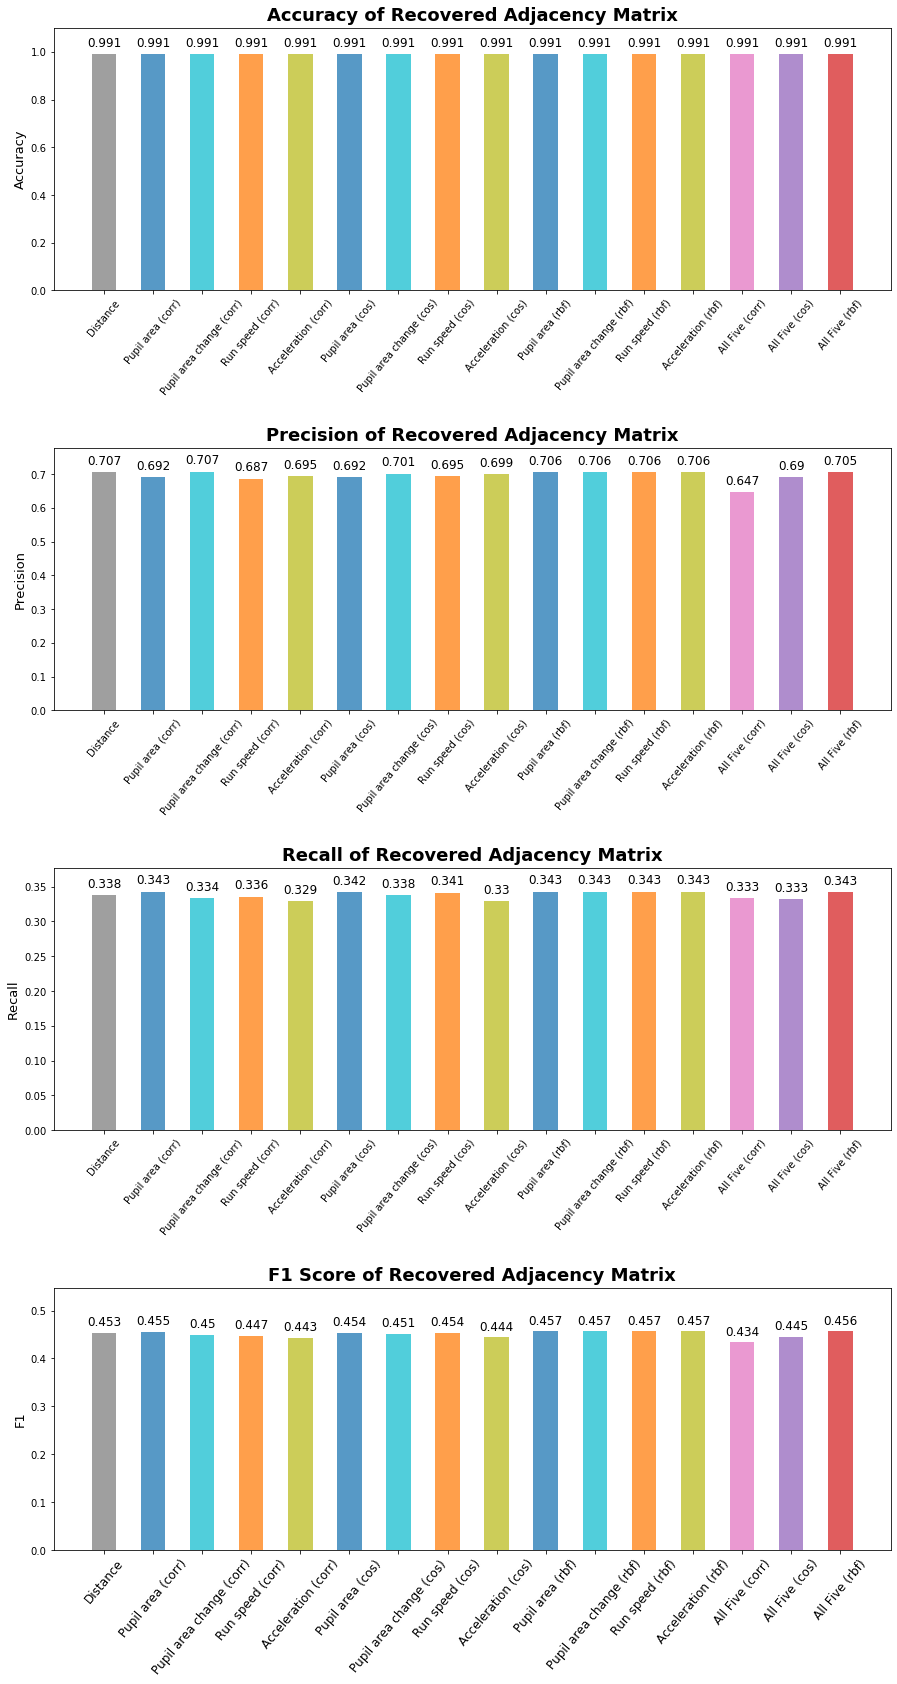

In [15]:
putils.display_results_diff_auxi(auxi_labels, session2res_auxi)


In [15]:
session2res_auxi['M150824_MP0192016-04-05']['results'][0].missing_entries_mask

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


## <font color='LightCoral'> Model: Random Forest Regressor </font>

In [16]:
fcr_config_rmf = FCRecoveryConfig(sessions=[0,1,3,4,5], loaded_sessions=loaded_spontData, 
                                  time_range=(100, 5100), sim_timestamps=30, auxi_mask=None, 
                                  layersOI=np.arange(4), xrange=(0.3, 0.6), yrange=(0.4, 0.6), 
                                  sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                                  full_Kfolds=5, glasso_alpha=0.15, rec_model=glb.RMF_REG, 
                                  edge_types=2, edge_cutoff_tol=1e-8)

In [17]:
session2res_auxi_rmf = diff_session_diff_auxi(fcr_config_rmf, auxi_masks, consecutive=True)


9 datasets to loaded

Session 0 loaded! M150824_MP0192016-04-05
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 0: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains 

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 1: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_us

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 3: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_us

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 4: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_us

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:88: RuntimeWarning: Mean of empty slice
  tc = np.nanmean(fsp_ibin, axis=1)


Session 5: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_us

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

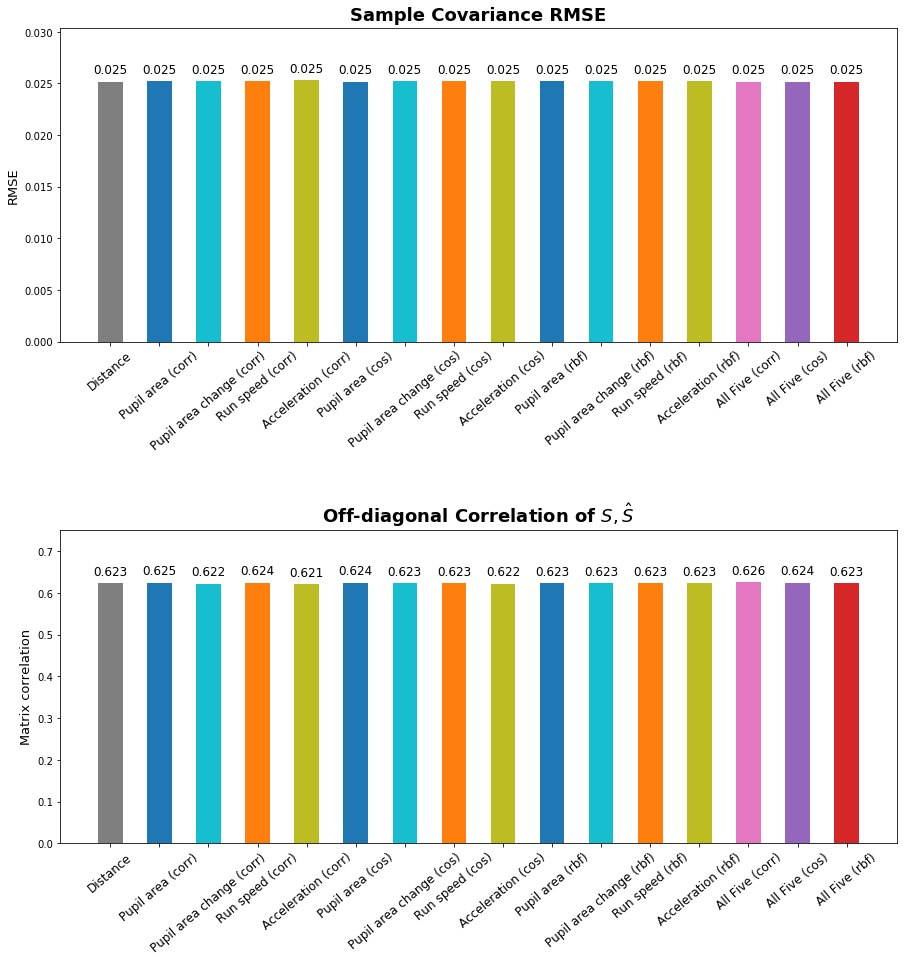

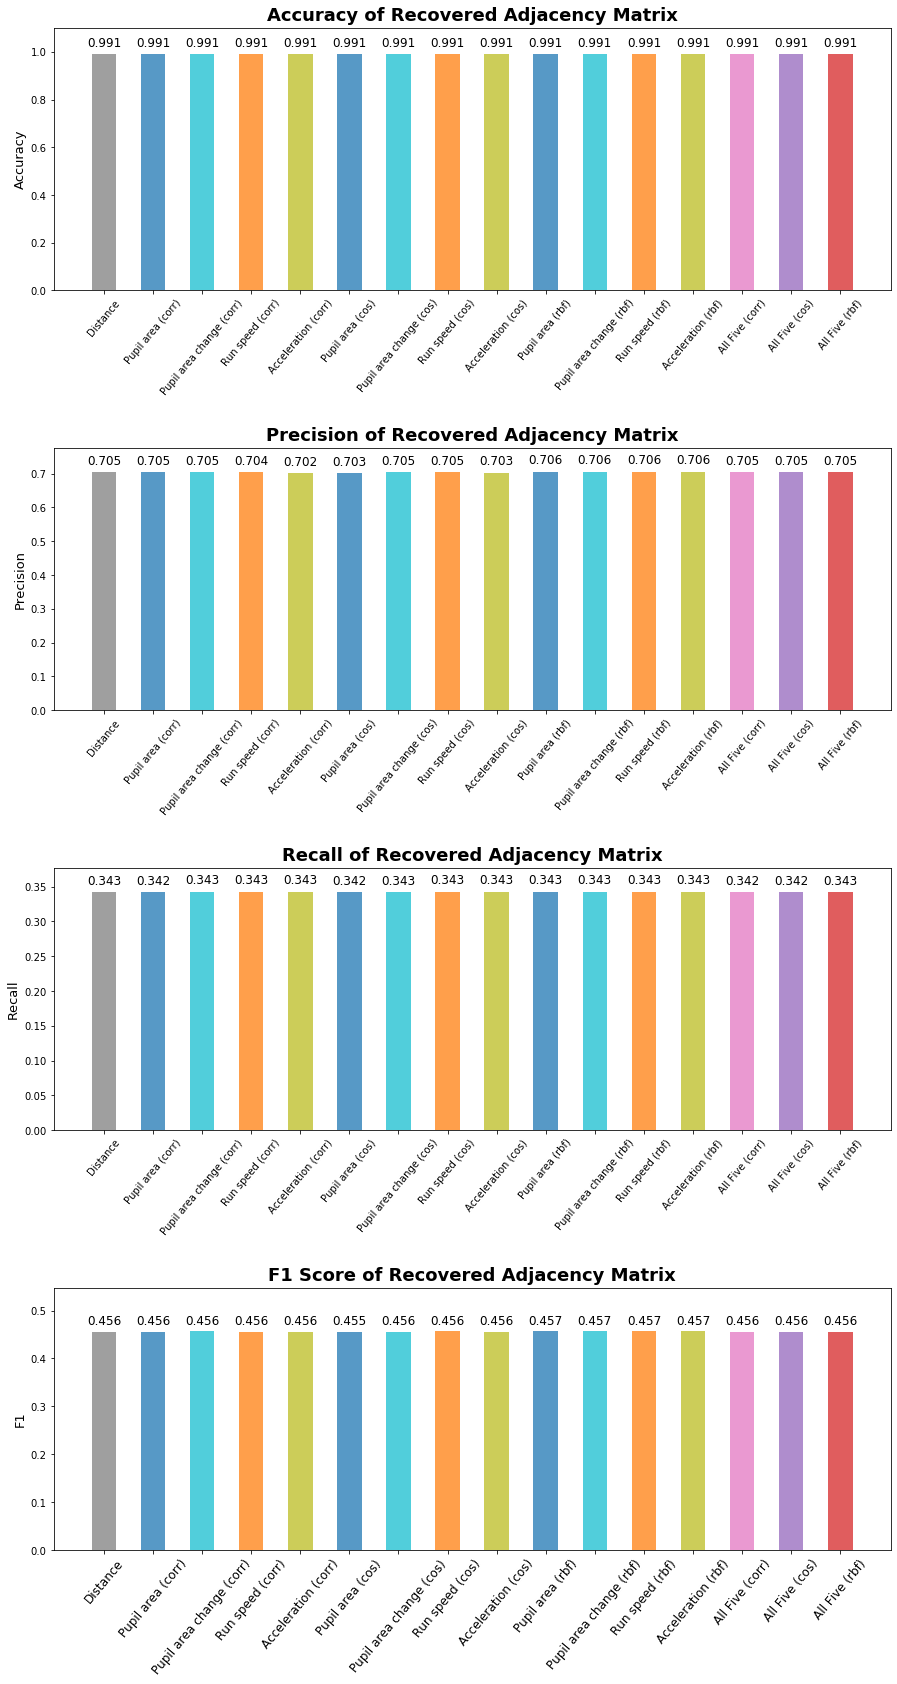

In [19]:
putils.display_results_diff_auxi(auxi_labels, session2res_auxi_rmf)


Optimal Lambda for full data:  None
Optimal Lambda for full data:  None
Optimal Lambda for full data:  None
Optimal Lambda for full data:  None
Optimal Lambda for full data:  None


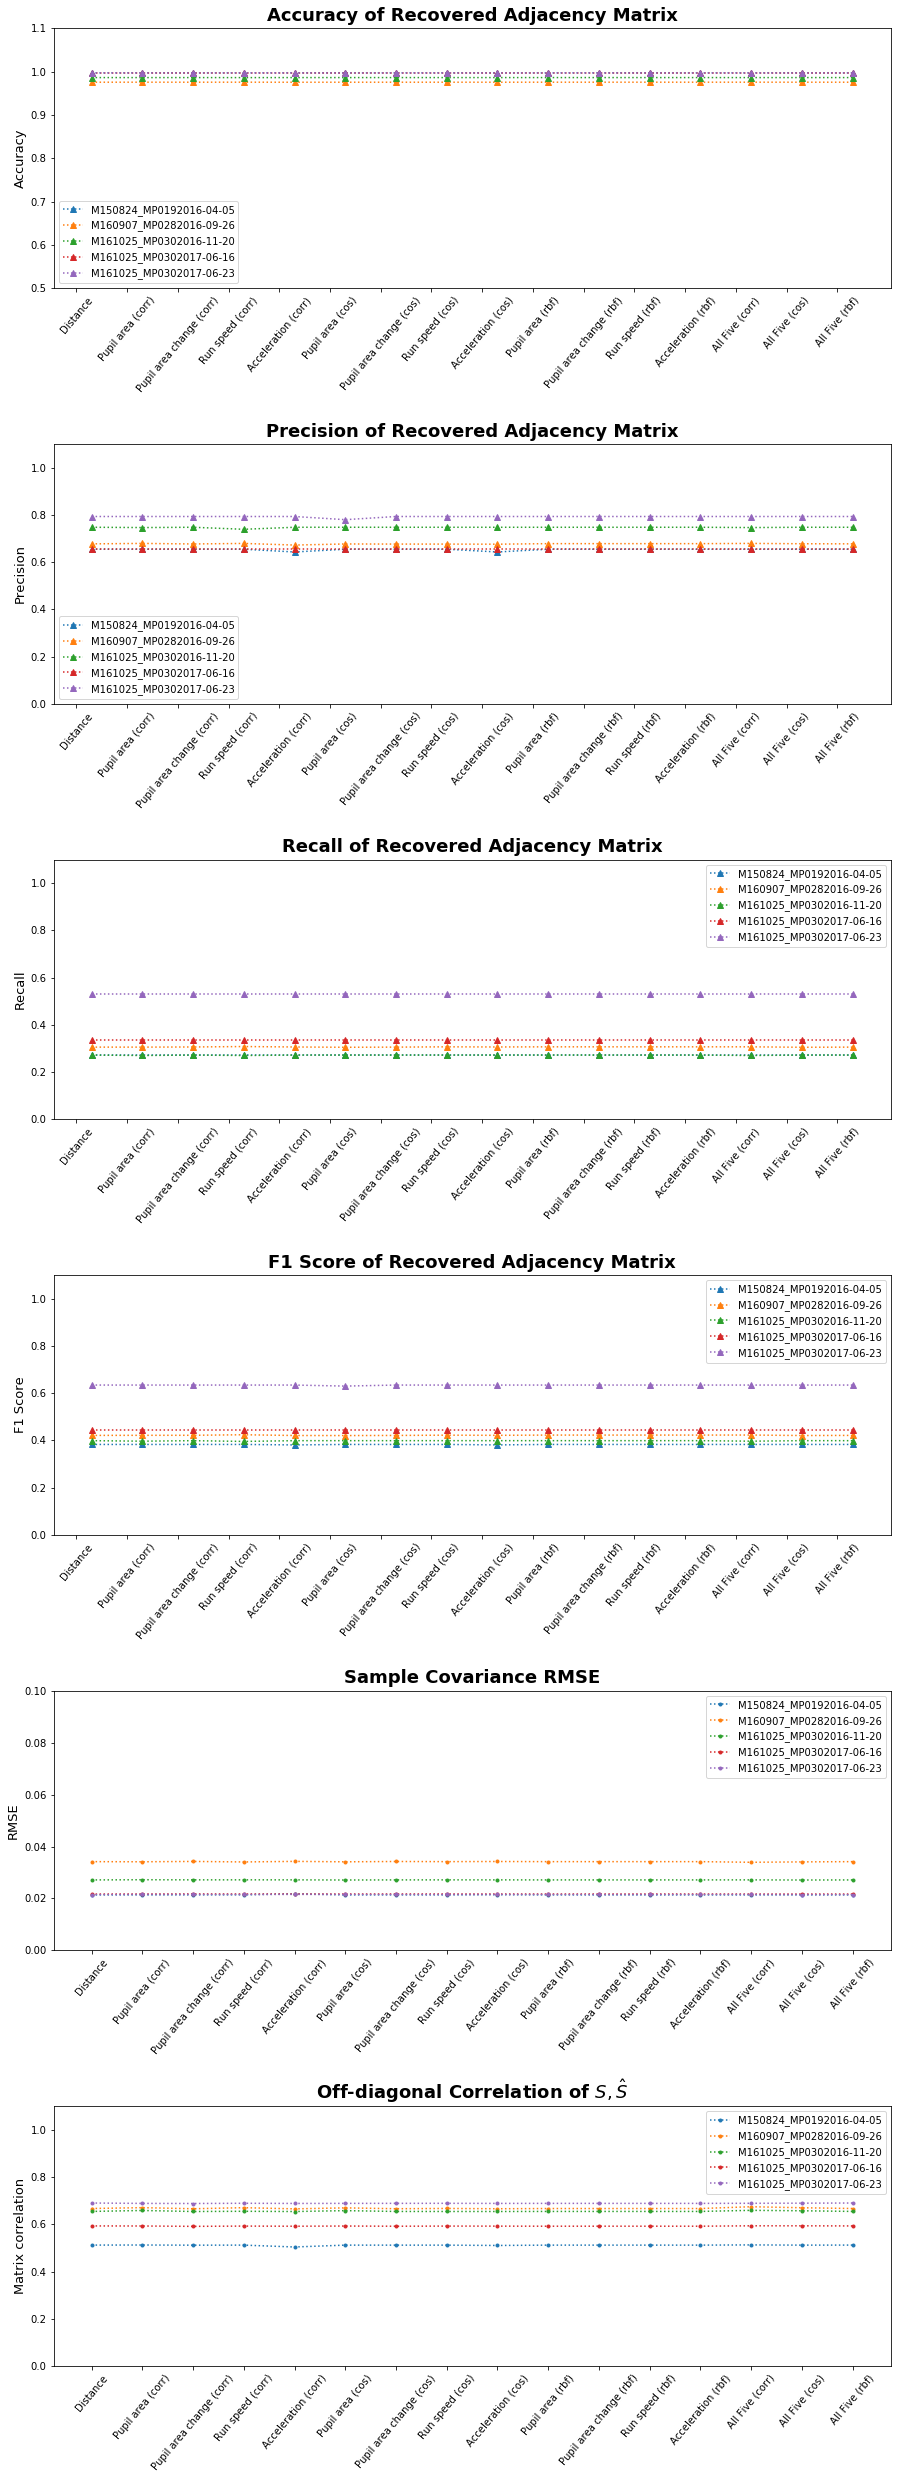

In [29]:
putils.display_results_diff_auxi_show_all_sessions(auxi_labels, session2res_auxi_rmf)


In [36]:
session2res_auxi_rmf['M150824_MP0192016-04-05']['missing_fsp'].shape

(314, 5000)

In [33]:
str(session2res_auxi_rmf['M150824_MP0192016-04-05']['results'][0])

'Ahat                 [[1. 0. 0. ... 0. 0. 0.]\n [0. 1. 0. ... 0. 0. 0.]\n [0. 0. 1. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 1. 0. 0.]\n [0. 0. 0. ... 0. 1. 0.]\n [0. 0. 0. ... 0. 0. 1.]]\nacc                  0.9976394456767261\nauxi_sigma_corr      0.5119793152703368\nauxi_sigma_err       0.02137942638413726\nf1                   0.38297872340425526\nfcRec_result         FCRecoveryResult(auxi_sigma=array([[1.00000000e+00, 5.10847355e-02, 9.16990178e-02, ...,\n        2.94586853e-03, 3.16305384e-03, 3.16305384e-03],\n       [5.10847355e-02, 1.00000000e+00, 3.88944881e-04, ...,\n        3.58819890e-03, 3.16305384e-03, 3.16305384e-03],\n       [9.16990178e-02, 3.88944881e-04, 1.00000000e+00, ...,\n        3.53458220e-03, 2.94850865e-03, 2.87543068e-03],\n       ...,\n       [2.94586853e-03, 3.58819890e-03, 3.53458220e-03, ...,\n        1.00000000e+00, 9.12556941e-03, 1.00529609e-02],\n       [3.16305384e-03, 3.16305384e-03, 2.94850865e-03, ...,\n        9.12556941e-03, 1.00000000e+00, 3.253

## <font color='LightCoral'> Model: XGBoost Regressor </font>

In [37]:
fcr_config_xgb = FCRecoveryConfig(sessions=[0,1,3,4,5], loaded_sessions=loaded_spontData, 
                                  time_range=(100, 5100), sim_timestamps=30, auxi_mask=None, 
                                  layersOI=np.arange(4), xrange=(0.3, 0.6), yrange=(0.4, 0.6), 
                                  sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                                  full_Kfolds=5, glasso_alpha=0.15, rec_model=glb.XGB_REG, 
                                  edge_types=2, edge_cutoff_tol=1e-8)

In [41]:
session2res_auxi_xgb = diff_session_diff_auxi(fcr_config_xgb, auxi_masks, consecutive=True)


9 datasets to loaded

Session 0 loaded! M150824_MP0192016-04-05
start, end time:  100 5100
Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  TC, N = tc_mat.shape


Session 0: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 314, 314)
Final Correlation matrix contains 

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  TC, N = tc_mat.shape


Session 1: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 335, 335)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_us

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  TC, N = tc_mat.shape


Session 3: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  (1, 261, 261)
Final Correlation matrix contains NaN? False
Perturbed cov is not PSD!
Auxi_mats_to_use:  

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  TC, N = tc_mat.shape


Session 4: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 306, 306)
Final Correlation matrix contains NaN? False
Auxi_mats_to_us

/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/data_sampler.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':
/Users/caratan/Desktop/Spring2021/AM231/Final_Project_code/utils.py:113: RuntimeWarning: Mean of empty slice
  TC, N = tc_mat.shape


Session 5: Pairwise Similarity Matrices Created!
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_use:  (1, 201, 201)
Final Correlation matrix contains NaN? False
Auxi_mats_to_us

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


<Figure size 432x288 with 0 Axes>

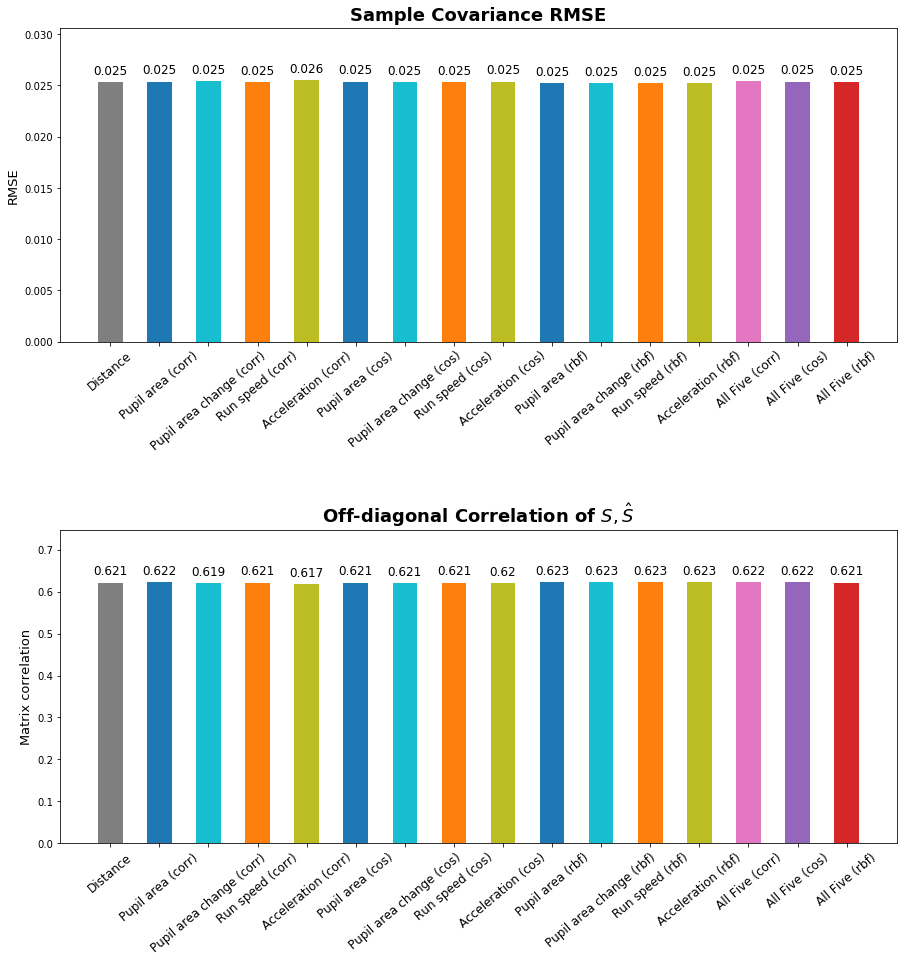

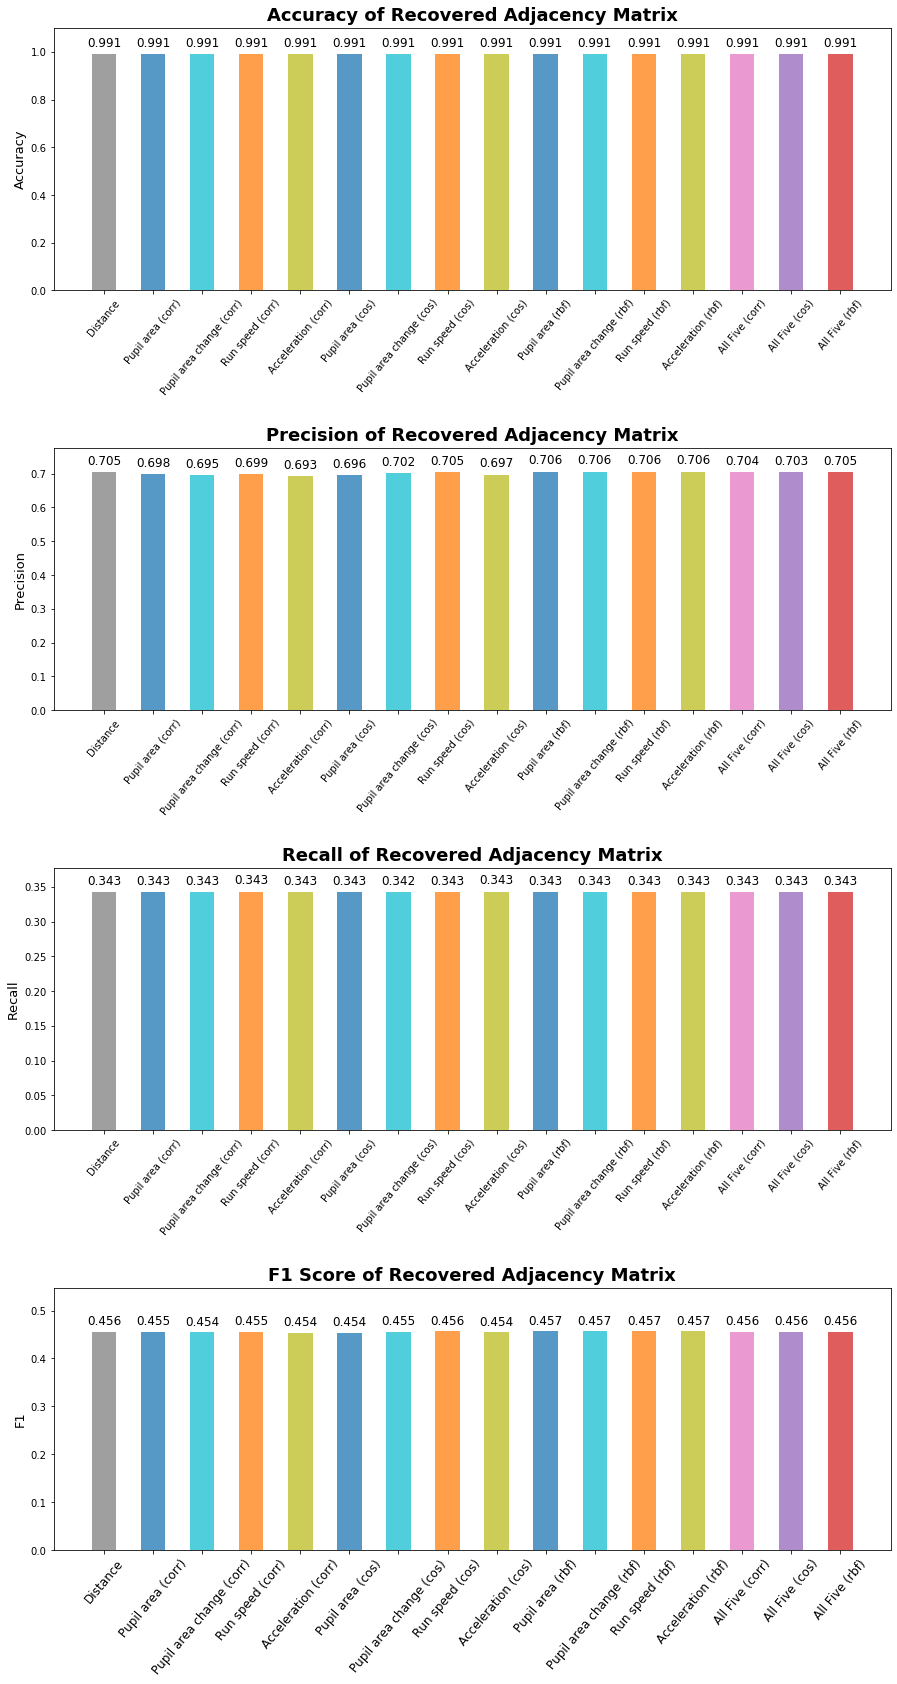

In [42]:
putils.display_results_diff_auxi(auxi_labels, session2res_auxi_xgb)


In [ ]:
session2res_auxi_xgb[]

In [ ]:
putils.display_results_diff_auxi(auxi_labels, session2res_auxi_xgb, target='missing')


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being

Optimal Lambda for full data:  None


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:391

<Figure size 432x288 with 0 Axes>

/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Optimal Lambda for full data:  None


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:391

<Figure size 432x288 with 0 Axes>

Optimal Lambda for full data:  None


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being

<Figure size 432x288 with 0 Axes>

/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being

Optimal Lambda for full data:  None


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being

<Figure size 432x288 with 0 Axes>

/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being

Optimal Lambda for full data:  None


/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/caratan/anaconda3/envs/python3-8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being

<Figure size 432x288 with 0 Axes>

In [ ]:
fcr_config = FCRecoveryConfig(sessions=[0], loaded_sessions=loaded_spontData, 
                              time_range=(100, 5100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.4, 0.6), yrange=(0.4, 0.6), 
                              sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.15, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [ ]:
session2res_auxi_ridge = diff_session_diff_auxi(fcr_config, auxi_masks, consecutive=True)


In [ ]:

putils.display_results_diff_auxi(auxi_labels, session2res_auxi_ridge)


In [ ]:
auxi_labels = ["Neuron distance", "Pupil area", "Pupil area change", "Run speed", "Acceleration", "All five"]
putils.display_results_diff_auxi(auxi_labels, session2res_auxi2)


# Missing Pattern: Interleaving Layers of Simultaneous Neuron Blocks

In [ ]:

fcr_config = FCRecoveryConfig(sessions=[1], time_range=(100, 1100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.2, 0.6), yrange=(0.2, 0.6), 
                              sim_layer_size=1, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.1, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)


In [ ]:
session2res_interleave = diff_session_diff_missing_by_layers(fcr_config, consecutive=False)


In [ ]:
for k in session2res_interleave.keys():
    print("\n\nSession: %s" % k)
    print("Number of neurons: ", session2res_interleave[k]['missing_fsp'].shape[0])
    print(session2res_interleave[k]['result'])
    